In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

import pickle

from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor
from os import walk

import re

from matplotlib.font_manager import FontProperties
fp2 = FontProperties(fname=r"../../fonts/Font Awesome 5 Free-Solid-900.otf")

In [91]:
dp = DataPreprocessor(drop_HS=True)
data = dp.preprocess_data("double_entry_final.csv", last_day="2020-05-30", schools_unis="lol")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Symptomatic Testing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
IN

In [3]:
default_res = pickle.load(open("final_full.pkl", "rb")).CMReduction

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '51979' (I am process '53398')


In [4]:
exp_dir = "../../server/additional_exps"

def load_exp(exp_num):
    return pickle.load(open(f"{exp_dir}/exp_{exp_num}.pkl", "rb"))

colors = [*sns.color_palette("bright"), *sns.color_palette("dark")]

In [97]:
derived_features = [ #()"Healthcare Infection Control", [0]),
 ("Mask Wearing       ", [0]),
 ("Gatherings <1000     ", [1]),
 ("Gatherings <100             ", [2, 1]),
 ("Gatherings <10                   ", [3, 2, 1]),
 ("Some Businesses Suspended      ", [4]),
 ("Most Businesses Suspended            ", [4, 5]),
 ("School Closure       ", [6]),
 ("University Closure       ", [7]),
 ("School and University Closure             ", [6, 7]),
 ("Stay Home Order (with exemptions)       ", [8]),  
 ]

cm_plot_style = [
#             ("\uf7f2", "tab:red"), # hospital symbol
            ("\uf963", "black"), # mask
            ("\uf0c0", "darkgrey"), # ppl
            ("\uf0c0", "dimgrey"), # ppl
            ("\uf0c0", "black"), # ppl
            ("\uf07a", "tab:orange"), # shop 1
            ("\uf07a", "tab:red"), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]

def produce_ranges(trace):
    means = np.mean(trace, axis=0)
    med = np.median(trace, axis=0)
    li = np.percentile(trace, 2.5, axis=0)
    ui = np.percentile(trace, 97.5, axis=0)
    lq = np.percentile(trace, 25, axis=0)
    uq = np.percentile(trace, 75, axis=0)
    return means, med, li, ui, lq, uq

def add_trace_to_plot(res, y_off, col, label, alpha, width, size=8):
    nS, _ = res.shape
    nF = len(derived_features)
    derived_samples = np.zeros((nS, nF))

    for f_i, (f, prodrows) in enumerate(derived_features):
        samples = np.ones(nS)
        for r in prodrows:
            samples = samples * res[:, r] 
        derived_samples[:, f_i] = samples

    res = derived_samples
    res = 100*(1-res)
    
    y_vals = -1 * np.arange(nF)
    plt.plot([100], [100], color=col, linewidth=1, alpha=alpha, label=label)
    mn, med, li, ui, lq, uq = produce_ranges(res)
    plt.scatter(med, y_vals+y_off, marker="|", color=col, s=size, alpha=alpha)
    for cm in range(nF):
        plt.plot([li[cm], ui[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.25, linewidth=width)
        plt.plot([lq[cm], uq[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.75, linewidth=width)
        
def setup_large_plot(y_ticks = True, icons = True, xlabel=True):
    nF = len(derived_features)
    x_min = -50
    x_max = 100
    plt.plot([0, 0], [1, -(nF)], "--k", linewidth=0.5)
    xrange = np.array([x_min, x_max])
    for height in range(0, nF+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="whitesmoke")
    xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    if y_ticks:
        plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=10)
    else:
        plt.yticks([])
    x_r = np.abs(x_min - x_max)
    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(nF - 0.25), 0.75])
    
    if icons:
        for cm in range(len(derived_features)):
            for i, val in enumerate(derived_features[cm][1]):
                plt.text(x_min - 7.5 - 13*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                             fontproperties=fp2, fontsize=12, color=cm_plot_style[val][1], zorder=-i, alpha = 1) 
                
    if xlabel:
        plt.xlabel("Average additional reduction in $R$, in the context of our data", fontsize=8)
        
class ResultsObject():
    def __init__(self, indx, trace):
        self.CMReduction = trace.CMReduction
        self.RegionR = trace.RegionR[:, indx]
        self.InfectedCases = trace.InfectedCases[:, indx, :]
        self.InfectedDeaths = trace.InfectedDeaths[:, indx, :]
        self.ExpectedCases = trace.ExpectedCases[:, indx, :]
        self.ExpectedDeaths = trace.ExpectedDeaths[:, indx, :]

In [126]:
from collections import defaultdict

nCMs = 9

def grab_traces_categorised(fname, verbose=False):
    global default_res
    
    files_found = 0
    all_traces = []
    cat_sen = defaultdict(list)
    for i, (dirpath, dirnames, filenames) in enumerate(walk(fname)):
        for f in filenames:
            if "_combined" in f and ".txt" in f and "rhat" not in f and "ess" not in f and "base" not in f:
                    
                trace = np.loadtxt(dirpath+"/"+f)
                nS, f_nCMs = trace.shape
                
                if f_nCMs > nCMs:
                    trace = trace[:, :nCMs]
                elif f_nCMs < nCMs:
                    leaveout_num = int(f[-5])
                    full_trace = np.zeros((nS, nCMs))
                    full_trace[:, :leaveout_num] = trace[:, :leaveout_num]
                    full_trace[:, leaveout_num] = default_res[:, leaveout_num]
                    full_trace[:, (leaveout_num+1):] = trace[:, leaveout_num:]
                    trace = full_trace
                
                files_found += 1
                
                res = trace
                    
                if "additive" in fname:
                    res = 1 - res
                    
                if "delay_mean_death" in f: 
                    cat_sen["Death Delay"].append((f, res))
                    files_found += 1
                
                    if verbose:
                        print(f"delays added {f}")
                
                if  "delay_mean_confirmed" in f: 
                    cat_sen["Cases Delay"].append((f, res))
                    files_found += 1
                
                    if verbose:
                        print(f"delays added {f}")
                    
                elif "serial_int" in f: 
                    cat_sen["Serial Interval"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"si added {f}")
                    
                elif "leavout" in f: 
                    cat_sen["NPI Leaveouts"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"leavouts added {f}")
                
                elif "R_hyperprior" in f: 
                    cat_sen["R Priors"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"epi prior {f}")
                        
                elif "cm_prior" in f: 
                    cat_sen["NPI Priors"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"epi prior {f}")
                        
                elif "noise" in f and "no_noise" not in f: 
                    cat_sen["Hyperparameter"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"hypers added {f}")
                        
                elif "regions_heldout" in f or "regholdout" in f: 
                    cat_sen["Region Holdouts"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"reg holdouts added {f}")
                    
                elif "schools" in f: 
                    cat_sen["SE Schools"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"mob added {f}")
                    
                elif "min_confirmed" in f: 
                    cat_sen["Minimum Confirmed Cases"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"min conf added {f}")
                        
                elif "min_deaths" in f: 
                    cat_sen["Minimum Deaths"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"min deaths added {f}")
                        
                elif "smoothing" in f: 
                    cat_sen["Smoothing"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"smooting {f}")
                
                elif "mobility" in f: 
                    cat_sen["Mobility"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"min conf added {f}")
                else:
                    print(f"File {f} not added - no category found")
        
    return cat_sen

def fname_to_label(f):
    if "regholdout" in f:
        return f[:2]
    
    if "regions_heldout" in f:
        return f[16:18]
    
    if "cm_prior" in f:
        if "wide" in f:
            return "Wide"
        
        if "half_normal" in f:
            return "Half Normal"
        
        if "icl" in f:
            return "Flaxman et. al."
    
    if "data_mobility" in f:
        if "no_work" in f:
            return "Retail & Recreation"
        elif "rec_work" in f:
            return "Workplace & Retail &\nRecreation"
    
    if "R_hyperprior" in f:
        if "0" in f:
            return "$\mu=2.5$"
        elif "1" in f:
            return "$\mu=4.5$"
    
    if "schools_open" in f:
        return "SE Schools Open"

    if "delay" in f and "confirmed" in f:
         if "0" in f:
            return "Cases Delay: $-4$ days"
         if "1" in f:
            return "Cases Delay: $-2$ days" 
         if "2" in f:
            return "Cases Delay: $+2$ days" 
         if "3" in f and "v3" not in f:
            return "Cases Delay: $+4$ days" 
    
    if "delay" in f and "death" in f:
         if "0" in f:
            return "Deaths Delay: $-4$ days"
         if "1" in f:
            return "Deaths Delay: $-2$ days" 
         if "2" in f:
            return "Deaths Delay: $+2$ days" 
         if "3" in f and "v3" not in f:
            return "Deaths Delay: $+4$ days" 

    if "cm_leavout" in f:
        if "0" in f:
            return "Mask Wearing"
        if "1" in f:
            return "Gatherings <1000"
        if "2" in f and "v3" not in f:
            return "Gatherings <100"
        if "3" in f:
            return "Gatherings <10"
        if "4" in f:
            return "Some Businesses Suspended"
        if "5" in f:
            return "Most Businesses Suspended"
        if "6" in f:
            return "School Closure"
        if "7" in f:
            return "University Closure"
        if "8" in f:
            return "Stay at Home Order"
        
    if "serial_int" in f:
        if "SI4" in f:
            return "$\mu=4$"
        if "SI5" in f:
            return "$\mu=5$"
        if "SI6" in f:
            return "$\mu=6$"
        if "SI7" in f:
            return "$\mu=7$"
        if "SI8" in f:
            return "$\mu=8$"
    
    if "min_confirmed" in f:
        if "v3" in f:
            val = re.findall('\\d+', f)[1]
        else:
            val = re.findall('\\d+', f)[0]
        return f"{val}"
    
    if "min_deaths" in f:
        if "v3" in f:
            val = re.findall('\\d+', f)[1]
        else:
            val = re.findall('\\d+', f)[0]
        return f"{val}"
    
    if "cm_prior_combined_additive" in f:
        if "10" in f:
            return "$\\alpha_i\sim$Dirichlet($\\alpha=10$)"
        if "5" in f:
            return "$\\alpha_i\sim$Dirichlet($\\alpha=5$)"
    
    if "smoothing" in f:
        if "v3" in f:
            val = re.findall('\\d+', f)[1]
        else:
            val = re.findall('\\d+', f)[0]
        return f"{val} days"
    
    if "growth_noise" in f and "0" in f:
        return "$\sigma_n=0.05$"
    
    if "growth_noise" in f and "1" in f:
        return "$\sigma_n=0.1$"
    
    if "growth_noise" in f and "2" in f:
        return "$\sigma_n=0.4$"
    
    return f

In [117]:
cat_sen = grab_traces_categorised("../../server/traces")

File delay_mean_death_combined_2.txt not added - no category found
File delay_mean_death_combined_3.txt not added - no category found
File delay_mean_death_combined_1.txt not added - no category found
File delay_mean_death_combined_0.txt not added - no category found


# Category 1: Structural Sensitivity

In [8]:
exp_add = 1
exp_noisyr = 2
exp_diff = 3
exp_dr = 4

res_add = load_exp(exp_add)
res_noisyr = load_exp(exp_noisyr)
res_diff = load_exp(exp_diff)
res_dr = load_exp(exp_dr)

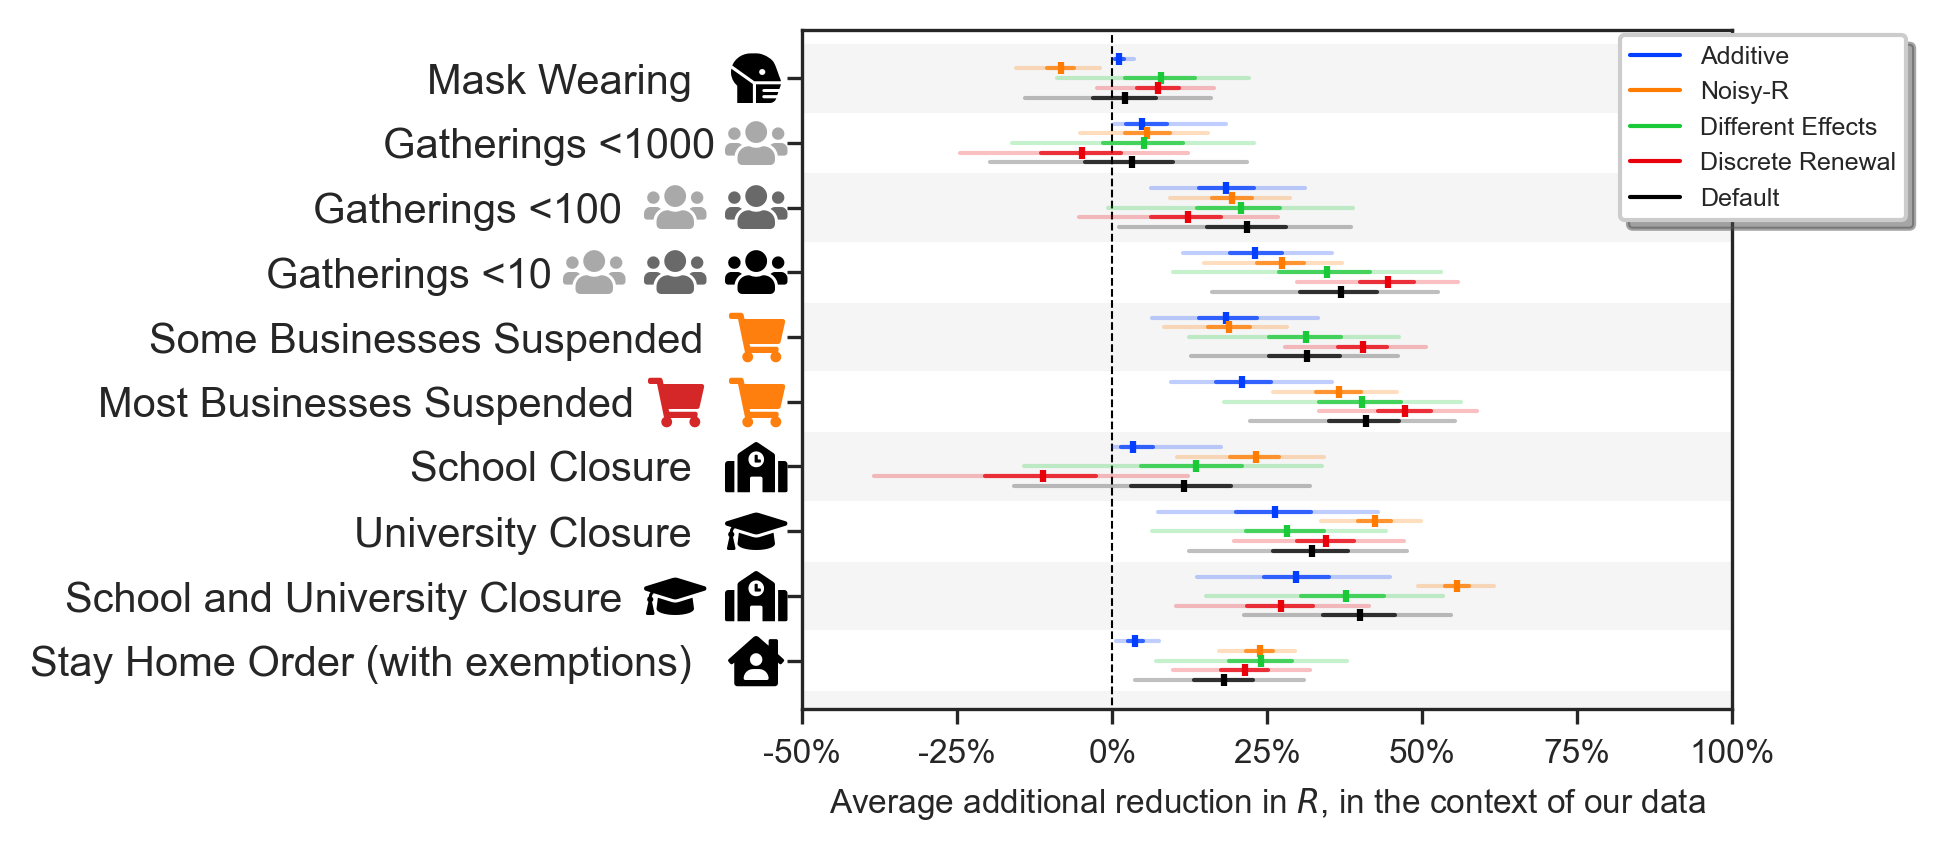

In [127]:
fig = plt.figure(figsize=(4, 3), dpi=300)

setup_large_plot()

y_off = -np.linspace(-0.3, 0.3, 5)
width = 1
add_trace_to_plot(1-res_add.CMReduction, y_off[0], colors[0], "Additive", 1, width) 
add_trace_to_plot(res_noisyr.CMReduction, y_off[1], colors[1], "Noisy-R", 1, width) 
add_trace_to_plot(res_diff.CMReduction, y_off[2], colors[2], "Different Effects", 1, width)
add_trace_to_plot(res_dr.CMReduction, y_off[3], colors[3], "Discrete Renewal", 1, width)
add_trace_to_plot(default_res, y_off[4], "k", "Default", 1, width) 
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)
plt.savefig(f"FigSSA.pdf", bbox_inches='tight')

# Category 2: Unobserved Effects

In [10]:
exp_travel = 5
exp_transport = 6
exp_int_movement = 7
exp_info = 8
exp_testing = 9
exp_mob_work = 10
exp_mob_retail = 11
exp_mob_both = 12


res_travel = load_exp(exp_travel)
res_transport = load_exp(exp_transport)
res_int_movement = load_exp(exp_int_movement)
res_info = load_exp(exp_info)
res_testing = load_exp(exp_testing)
res_mob_work = load_exp(exp_mob_work)
res_mob_retail = load_exp(exp_mob_retail)
res_mob_both = load_exp(exp_mob_both)

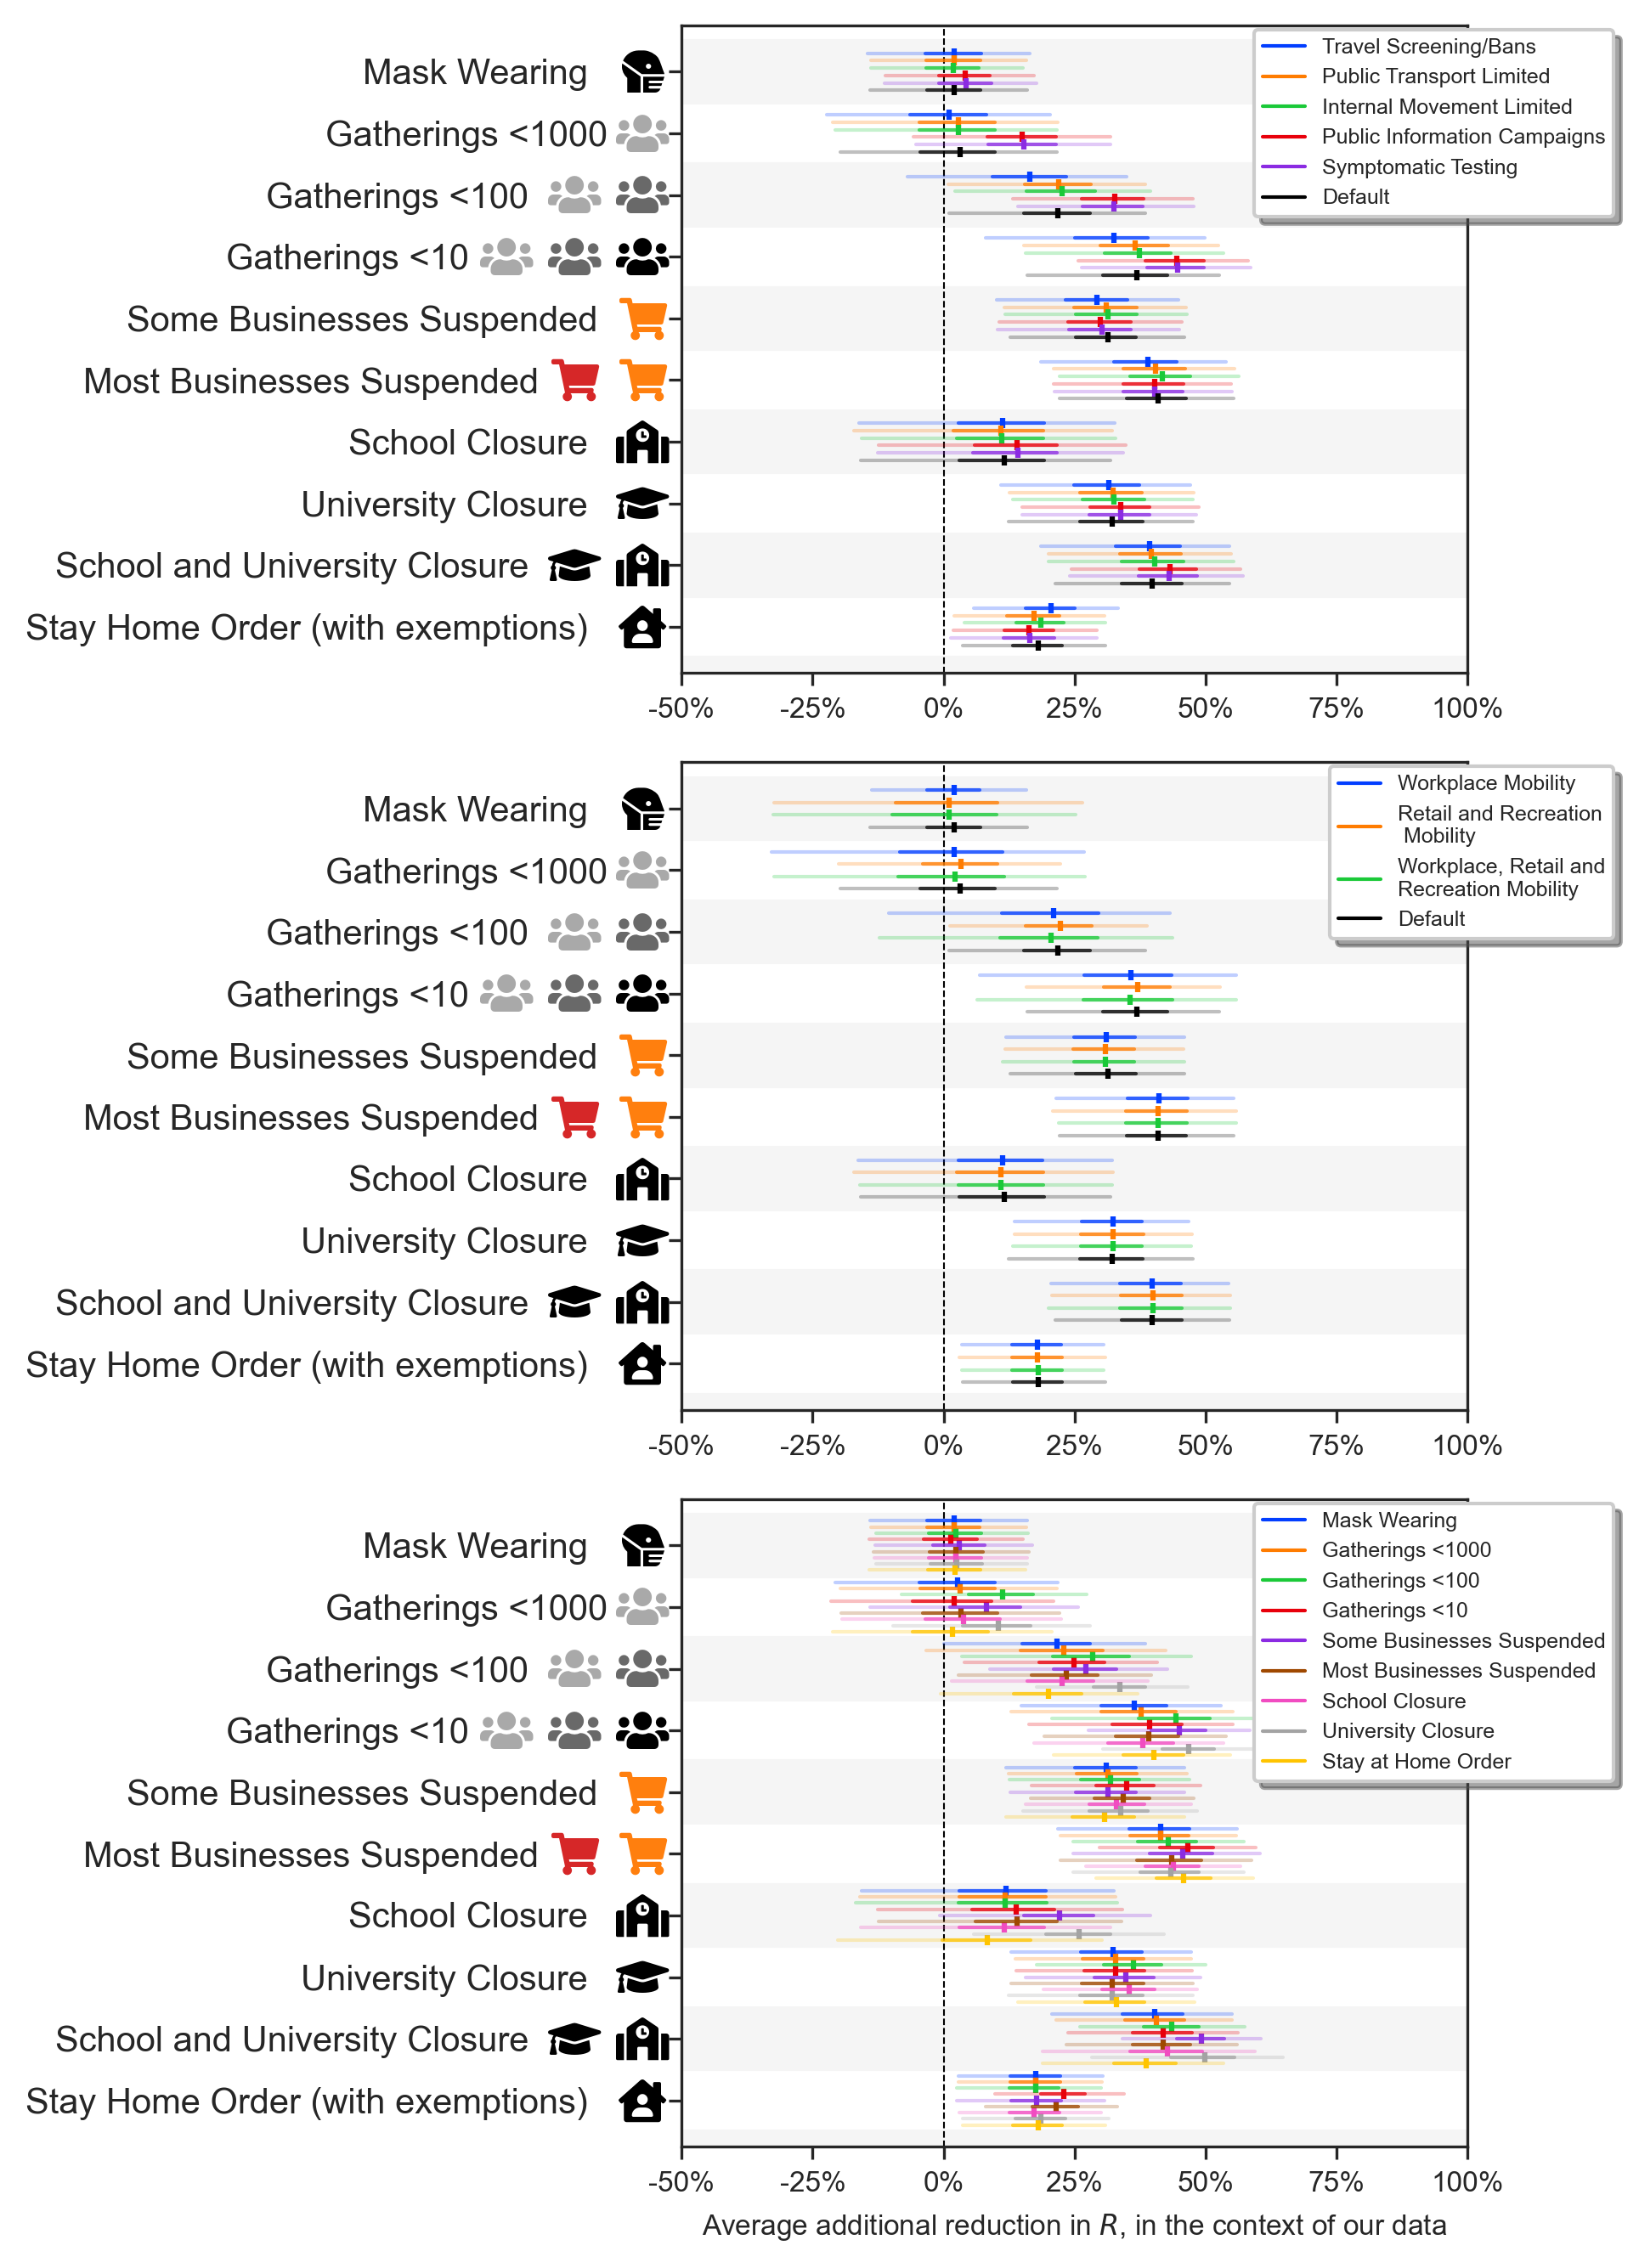

In [128]:
fig = plt.figure(figsize=(7, 9), dpi=300)

plt.subplot(311)
setup_large_plot(xlabel=False)

y_off = -np.linspace(-0.3, 0.3, 6)
width = 1
add_trace_to_plot(res_travel.CMReduction[:, :9], y_off[0], colors[0], "Travel Screening/Bans", 1, width) 
add_trace_to_plot(res_transport.CMReduction[:, :9], y_off[1], colors[1], "Public Transport Limited", 1, width) 
add_trace_to_plot(res_int_movement.CMReduction[:, :9], y_off[2], colors[2], "Internal Movement Limited", 1, width)
add_trace_to_plot(res_info.CMReduction[:, :9], y_off[3], colors[3], "Public Information Campaigns", 1, width)
add_trace_to_plot(res_testing.CMReduction[:, [0, 2, 3, 4, 5, 6, 7, 8, 9]], y_off[4], colors[4], "Symptomatic Testing", 1, width)
add_trace_to_plot(default_res, y_off[5], "k", "Default", 1, width) 

plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)

plt.subplot(312)
setup_large_plot(xlabel=False)

y_off = -np.linspace(-0.3, 0.3, 4)
width = 1
add_trace_to_plot(res_mob_work.CMReduction[:, :9], y_off[0], colors[0], "Workplace Mobility", 1, width) 
add_trace_to_plot(res_mob_retail.CMReduction[:, :9], y_off[1], colors[1], "Retail and Recreation\n Mobility", 1, width) 
add_trace_to_plot(res_mob_both.CMReduction[:, :9], y_off[2], colors[2], "Workplace, Retail and\nRecreation Mobility", 1, width)
add_trace_to_plot(default_res, y_off[3], "k", "Default", 1, width) 

plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)

plt.subplot(313)
setup_large_plot()


cat_sen["NPI Leaveouts"].sort(key = lambda x: x[0])

y_off = -np.linspace(-0.4, 0.4, len(cat_sen["NPI Leaveouts"]))

for i, (f, t) in enumerate(cat_sen["NPI Leaveouts"]):
    add_trace_to_plot(t, y_off[i], colors[i], fname_to_label(f), 1, width)
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)

plt.tight_layout()
plt.savefig(f"FigUOB.pdf", bbox_inches='tight')

# Category 3: Data

In [60]:
exp_active = 18
exp_death = 19

res_active = load_exp(exp_active)
res_death = load_exp(exp_death)

In [135]:
[fname_to_label(f) for f, _ in cat_sen["Smoothing"]]

['3 days', '1 days', '7 days', '15 days']

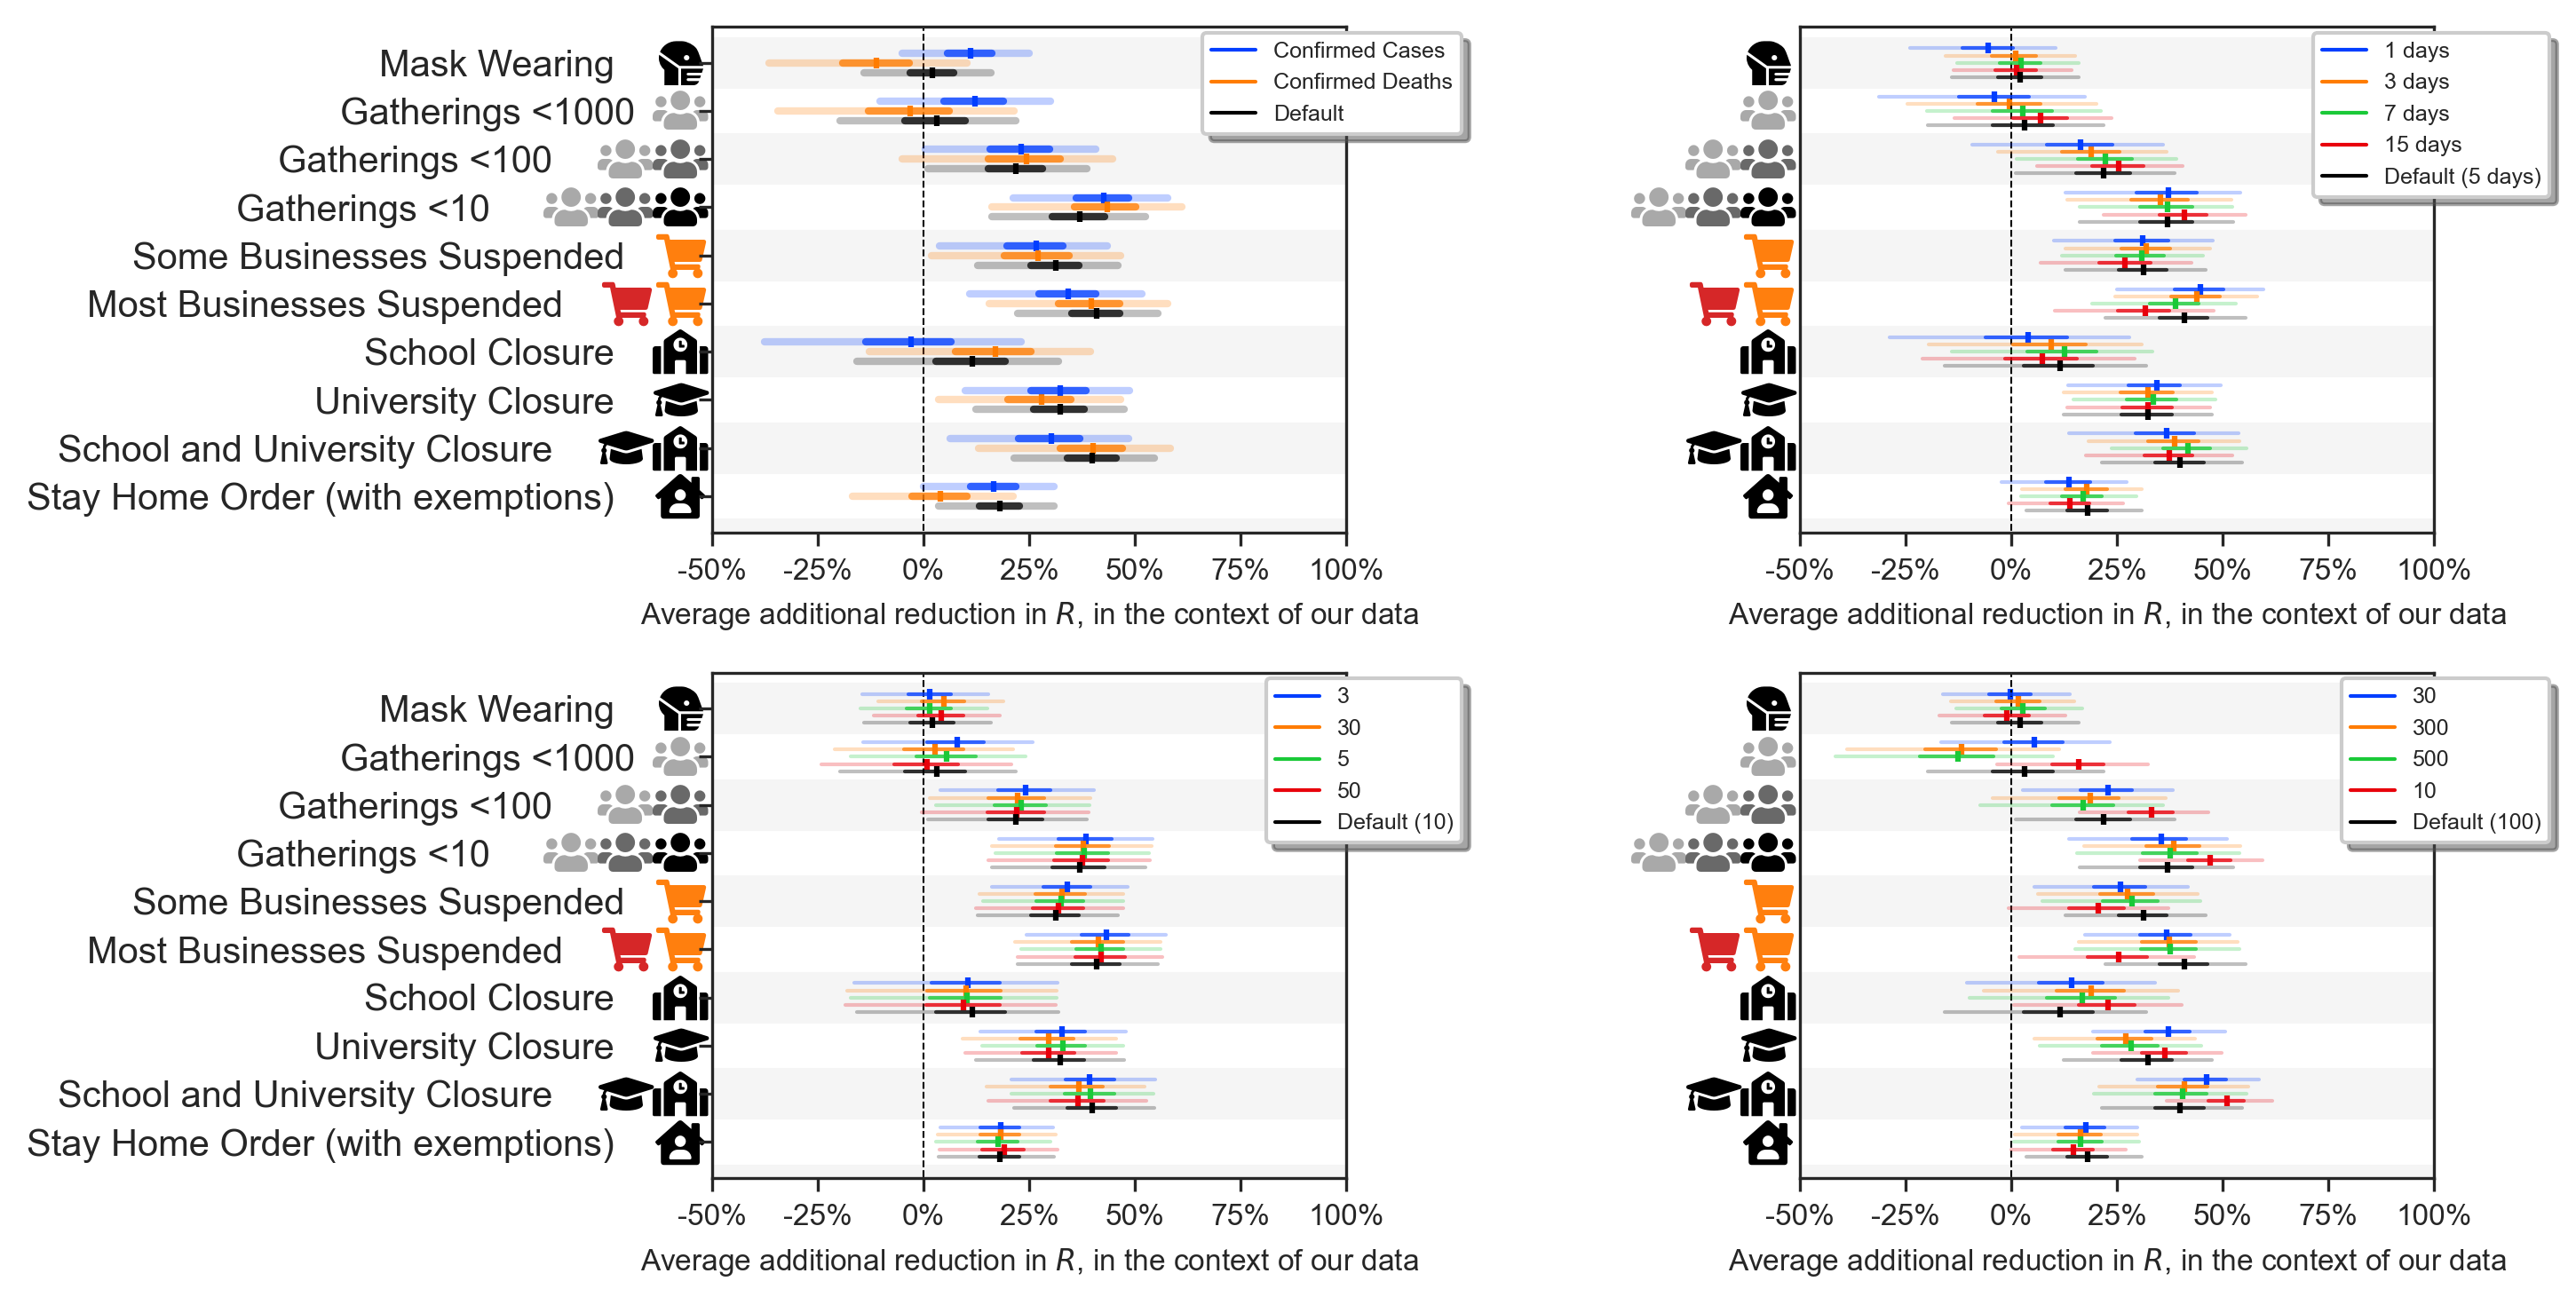

In [139]:
fig = plt.figure(figsize=(10, 5), dpi=300)

plt.subplot(221)
setup_large_plot()
y_off = -np.linspace(-0.2, 0.2, 3)
width = 2
add_trace_to_plot(res_active.CMReduction, y_off[0], colors[0], "Confirmed Cases", 1, width) 
add_trace_to_plot(res_death.CMReduction, y_off[1], colors[1], "Confirmed Deaths", 1, width) 
add_trace_to_plot(default_res, y_off[2], "k", "Default", 1, width)
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)

width=1
plt.subplot(222)
setup_large_plot(False, True)
cat_sen["Smoothing"].sort(key = lambda x: int(fname_to_label(x[0])[:2]))

y_off = -np.linspace(-0.3, 0.3, len(cat_sen["Smoothing"])+1)

for i, (f, t) in enumerate(cat_sen["Smoothing"]):
    add_trace_to_plot(t, y_off[i], colors[i], fname_to_label(f), 1, width)
add_trace_to_plot(default_res, y_off[-1], "k", "Default (5 days)", 1, width)
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)

plt.subplot(223)
setup_large_plot()
cat_sen["Minimum Deaths"].sort(key = lambda x: x[0])

y_off = -np.linspace(-0.3, 0.3, len(cat_sen["Minimum Deaths"])+1)

for i, (f, t) in enumerate(cat_sen["Minimum Deaths"]):
    add_trace_to_plot(t, y_off[i], colors[i], fname_to_label(f), 1, width)
add_trace_to_plot(default_res, y_off[-1], "k", "Default (10)", 1, width)
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)

plt.subplot(224)
setup_large_plot(False)
cat_sen["Minimum Confirmed Cases"].sort(key = lambda x: int(fname_to_label(f)[:3]))

y_off = -np.linspace(-0.3, 0.3, len(cat_sen["Minimum Confirmed Cases"])+1)

for i, (f, t) in enumerate(cat_sen["Minimum Confirmed Cases"]):
    add_trace_to_plot(t, y_off[i], colors[i], fname_to_label(f), 1, width)
add_trace_to_plot(default_res, y_off[-1], "k", "Default (100)", 1, width)
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)

plt.tight_layout()
plt.savefig(f"FigD1.pdf", bbox_inches='tight')

In [93]:
len(data.Rs)

41

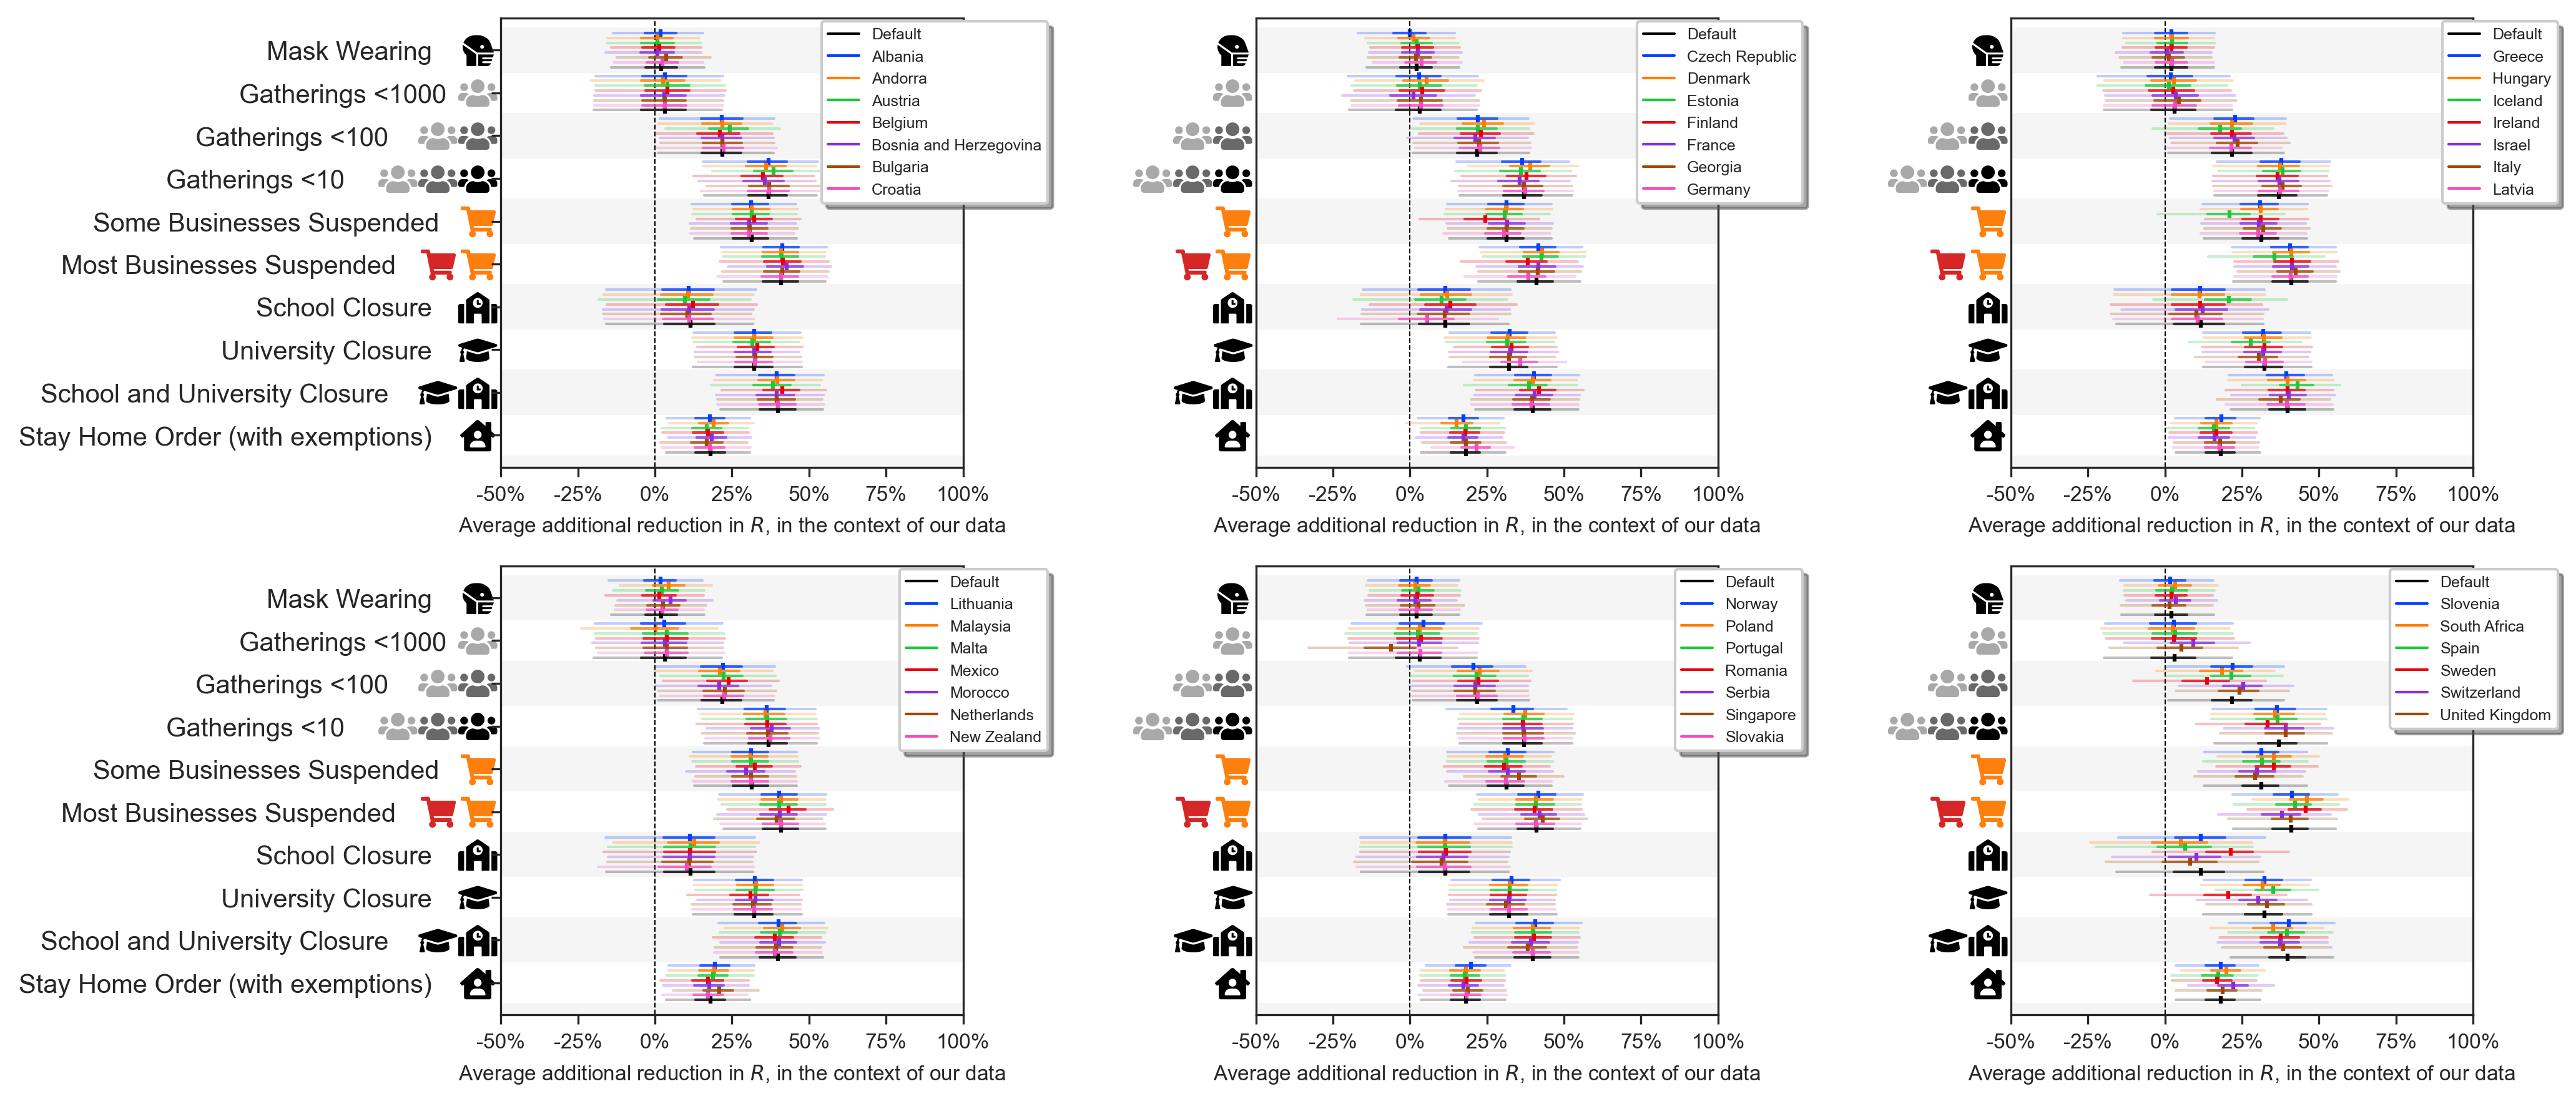

In [130]:
fig = plt.figure(figsize=(14, 6), dpi=300)

y_off = -np.linspace(-0.4, 0.4, 8)
for r_i, r in enumerate(data.Rs):
    r_i_p = r_i % 7 
    if r_i_p == 0:
        plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)
        plt.subplot(2, 3, int(r_i/7) + 1)
        if (int(r_i/7) + 1) == 1 or (int(r_i/7) + 1) == 4:
            setup_large_plot()
        else:
            setup_large_plot(False)
        add_trace_to_plot(default_res, y_off[-1], "k", "Default", 1, 1)
    res = pickle.load(open(f"../../server/ho_results_final4/{r}.pkl", "rb")).CMReduction
    add_trace_to_plot(res, y_off[r_i_p], colors[r_i_p], data.RNames[r][0], 1, 1)
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)
plt.tight_layout()
plt.savefig(f"FigD2.pdf", bbox_inches='tight')

# Category 4: NPI timing

In [27]:
np.mean(res_mob_both.CMReduction[:, -2])

0.9959656110653351

In [12]:
exp_any_active = 13
exp_mm = 14
exp_difdelay = 15
exp_schools_delay = 16

res_any_active = load_exp(exp_any_active)
res_mm = load_exp(exp_mm)
res_difdelay = load_exp(exp_difdelay)
res_schoolsdelay = load_exp(exp_schools_delay)

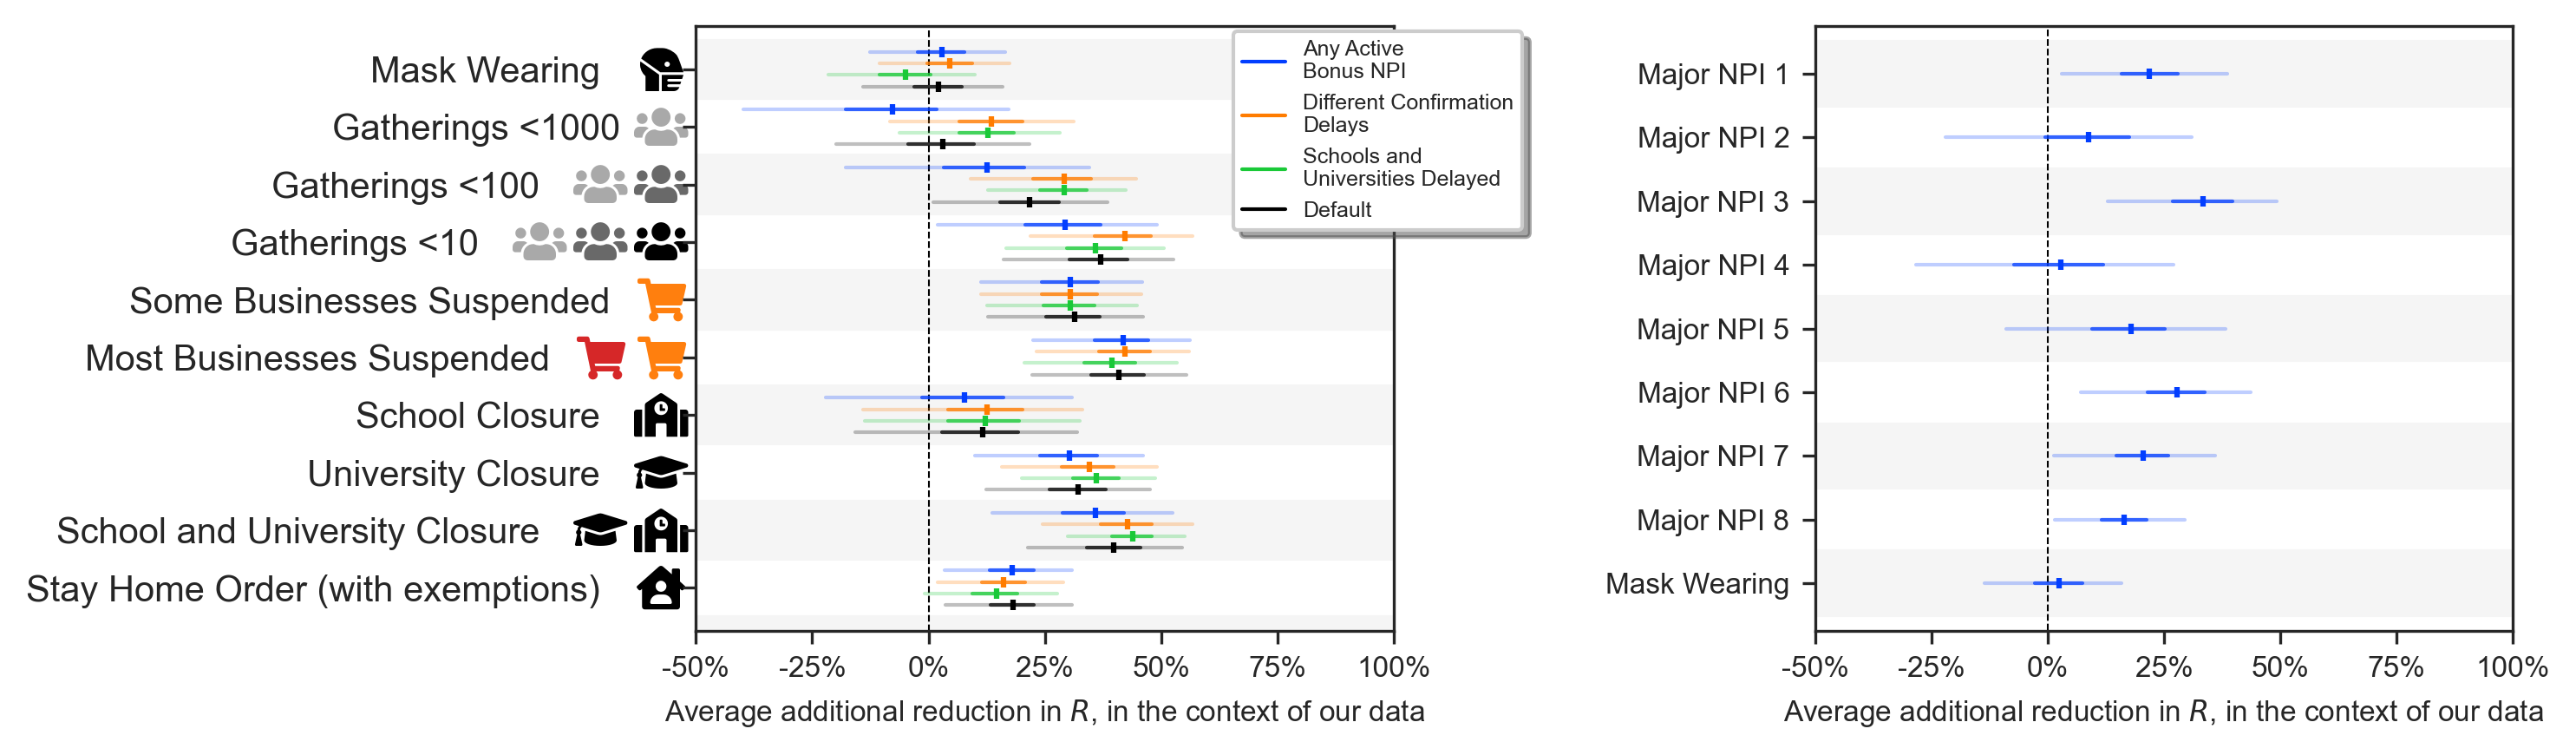

In [150]:
fig = plt.figure(figsize=(10, 3), dpi=300)

plt.subplot(121)
setup_large_plot()

y_off = -np.linspace(-0.3, 0.3, 4)
width = 1
add_trace_to_plot(res_any_active.CMReduction, y_off[0], colors[0], "Any Active\nBonus NPI", 1, width) 
add_trace_to_plot(res_difdelay.CMReduction[:, [0, 2, 3, 4, 5, 6, 7, 8, 9]], y_off[1], colors[1], "Different Confirmation\nDelays", 1, width) 
add_trace_to_plot(res_schoolsdelay.CMReduction, y_off[2], colors[2], "Schools and\nUniversities Delayed", 1, width)
add_trace_to_plot(default_res, y_off[3], "k", "Default", 1, width) 
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)

plt.subplot(122)
setup_large_plot(False, False)
npis = [f"Major NPI {i+1}" for i in range(8)]
npis.append("Mask Wearing")
plt.yticks(-np.arange(len(npis)), npis, fontsize=8)
plt.ylim([-(len(npis) - 0.25), 0.75])

y_vals = -1 * np.arange(len(npis))
plt.plot([100], [100], color=colors[0], linewidth=1, alpha=1, label="")
mn, med, li, ui, lq, uq = produce_ranges(100*(1-res_mm.CMReduction))
plt.scatter(med, y_vals, marker="|", color=colors[0], s=8, alpha=1)
for cm in range(len(npis)):
    plt.plot([li[cm], ui[cm]], [y_vals[cm], y_vals[cm]], color=colors[0], alpha=0.25, linewidth=width)
    plt.plot([lq[cm], uq[cm]], [y_vals[cm], y_vals[cm]], color=colors[0], alpha=0.75, linewidth=width)

plt.tight_layout()
plt.savefig(f"FigNPITiming.pdf", bbox_inches='tight')

# Category 5: epidemiological

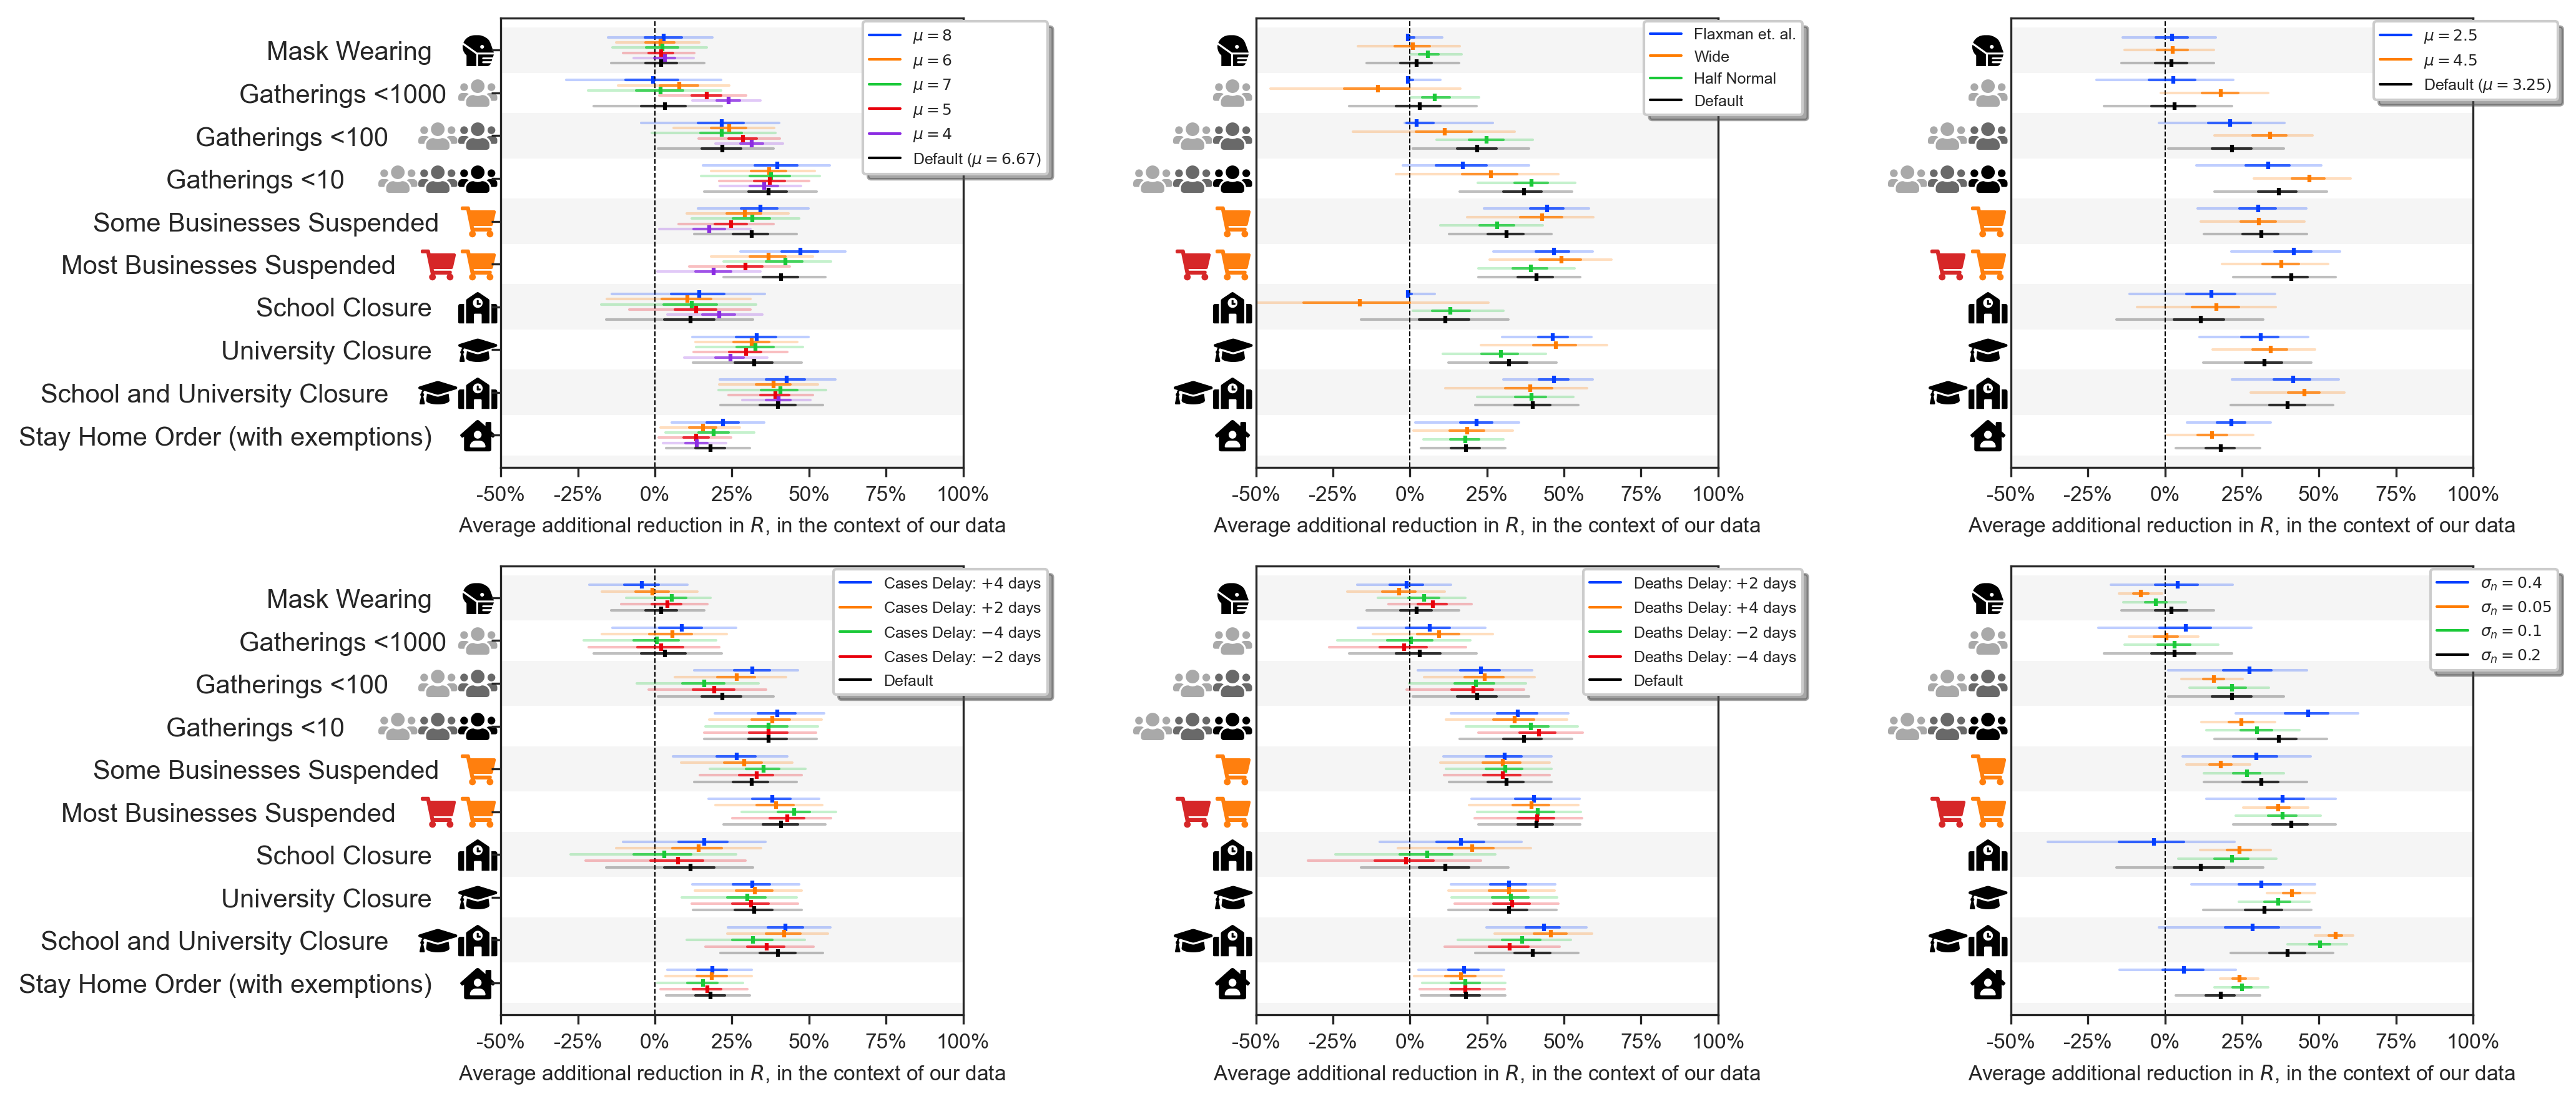

In [132]:
fig = plt.figure(figsize=(14, 6), dpi=300)

plt.subplot(231)
cat = "Serial Interval"
setup_large_plot()
cat_sen[cat].sort(key = lambda x: f)

y_off = -np.linspace(-0.3, 0.3, len(cat_sen[cat])+1)

for i, (f, t) in enumerate(cat_sen[cat]):
    add_trace_to_plot(t, y_off[i], colors[i], fname_to_label(f), 1, width)
add_trace_to_plot(default_res, y_off[-1], "k", "Default ($\mu = 6.67$)", 1, width)
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)

plt.subplot(232)
cat = "NPI Priors"
setup_large_plot(False)
cat_sen[cat].sort(key = lambda x: f)

y_off = -np.linspace(-0.3, 0.3, len(cat_sen[cat])+1)

for i, (f, t) in enumerate(cat_sen[cat]):
    add_trace_to_plot(t, y_off[i], colors[i], fname_to_label(f), 1, width)
add_trace_to_plot(default_res, y_off[-1], "k", "Default", 1, width)
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)

plt.subplot(233)
cat = "R Priors"
setup_large_plot(False)
cat_sen[cat].sort(key = lambda x: f)

y_off = -np.linspace(-0.3, 0.3, len(cat_sen[cat])+1)

for i, (f, t) in enumerate(cat_sen[cat]):
    add_trace_to_plot(t, y_off[i], colors[i], fname_to_label(f), 1, width)
add_trace_to_plot(default_res, y_off[-1], "k", "Default ($\mu=3.25$)", 1, width)
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)

plt.subplot(234)
cat = "Cases Delay"
setup_large_plot()
cat_sen[cat].sort(key = lambda x: f)

y_off = -np.linspace(-0.3, 0.3, len(cat_sen[cat])+1)

for i, (f, t) in enumerate(cat_sen[cat]):
    add_trace_to_plot(t, y_off[i], colors[i], fname_to_label(f), 1, width)
add_trace_to_plot(default_res, y_off[-1], "k", "Default", 1, width)
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)

plt.subplot(235)
cat = "Death Delay"
setup_large_plot(False)
cat_sen[cat].sort(key = lambda x: f)

y_off = -np.linspace(-0.3, 0.3, len(cat_sen[cat])+1)

for i, (f, t) in enumerate(cat_sen[cat]):
    add_trace_to_plot(t, y_off[i], colors[i], fname_to_label(f), 1, width)
add_trace_to_plot(default_res, y_off[-1], "k", "Default", 1, width)
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)

plt.subplot(236)
cat = "Hyperparameter"
setup_large_plot(False)
cat_sen[cat].sort(key = lambda x: f)

y_off = -np.linspace(-0.3, 0.3, len(cat_sen[cat])+1)

for i, (f, t) in enumerate(cat_sen[cat]):
    add_trace_to_plot(t, y_off[i], colors[i], fname_to_label(f), 1, width)
add_trace_to_plot(default_res, y_off[-1], "k", "$\sigma_n = 0.2$", 1, width)
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)


plt.tight_layout()
plt.savefig(f"FigEpi.pdf", bbox_inches='tight')

# Aggregated Holdout Plot

In [144]:
dp.drop_features = ["Travel Screen/Quarantine", "Travel Bans", "Public Transport Limited",
                              "Internal Movement Limited",
                              "Public Information Campaigns"]
data = dp.preprocess_data("../../notebooks/double-entry-data/double_entry_final.csv", last_day="2020-05-30",
                          schools_unis="whoops")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Singapore
IN

In [146]:
data.CMs

['Mask Wearing',
 'Symptomatic Testing',
 'Gatherings <1000',
 'Gatherings <100',
 'Gatherings <10',
 'Some Businesses Suspended',
 'Most Businesses Suspended',
 'School Closure',
 'University Closure',
 'Stay Home Order']

In [148]:
short_rs = np.nonzero(np.sum(data.ActiveCMs[:, 1, :], axis=-1) > 1)[0]

In [149]:
short_rs

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 19, 21,
       22, 25, 27, 30, 31, 32, 33, 35, 36, 37, 39])

In [155]:
data = dp.preprocess_data("../../notebooks/double-entry-data/double_entry_final_mob.csv", last_day="2020-05-30",
                                  schools_unis="whoops")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Singapore
IN

In [160]:
data.CMs

['Mask Wearing',
 'Symptomatic Testing',
 'Gatherings <1000',
 'Gatherings <100',
 'Gatherings <10',
 'Some Businesses Suspended',
 'Most Businesses Suspended',
 'School Closure',
 'University Closure',
 'Stay Home Order',
 'Mobility - retail and rec',
 'Mobility - workplace']

In [165]:
data.ActiveCMs[:, 11]

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [168]:
data.ActiveCMs[0, 11, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])